In [1]:
"""
 Copyright (C) 2016 Elvis Teixeira

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np
from scipy.stats import multivariate_normal as normal
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
def load_data(file, sep='\s+'):
    """
    Returns a pandas.DataFrame object containing
    the data in the csv file
    """
    return pd.read_csv(file, sep=sep)


def sample_data(data, train_frac):
    """
    This function separates a fraction of the available
    data to be used as training set and the remainder as
    the validation set. The sampling is random
    """
    copy = data.copy()
    copy.reindex(np.random.permutation(copy.index))
    train_count = int(train_frac * copy.shape[0])
    # yield training set attrs and labels
    yield copy.ix[:train_count,:-1].as_matrix()
    yield copy.ix[:train_count,-1].as_matrix()
    # yield validation set attrs and labels
    yield copy.ix[train_count:,:-1].as_matrix()
    yield copy.ix[train_count:,-1].as_matrix()


# Sample a random training set and a validation set
# Also evaluate the covariance matrix of the training set to
# be used as the covariance for the basis functions
xt, yt, xv, yv = sample_data(load_data('dataset.txt'), 0.6667)
sigma = np.cov(xt.T)

In [3]:
def create_means(min_m, max_m, dim=4, count=1):
    """
    Creates randomly positioned means for the gaussian
    basis functions
    """
    means = {}
    for m in range(min_m, max_m):
        means[m] = np.random.uniform(0.0, 1.0, (m, dim))
    return means


def gauss_basis(x, mu, cov=sigma):
    """
    Basis function for our regression expreriment,
    this is a multivariate gaussian
    """
    return normal.pdf(x, mu, cov)


# This is a "dictionary of vectors" where each is a mean
# for a basis function
means = create_means(1, 30)

In [4]:
def regression(design, y, lamb):
    """
    Performs a batch regularized linear regression
    """
    lambI = lamb * np.identity(design.shape[1])
    w1 = lambI + np.dot(design.T, design)
    w2 = np.dot(np.linalg.inv(w1), design.T)
    return np.dot(w2, y)


def learn(x, y, lamb, basis, num_basis, means):
    """
    Creates the design matrix and performs the
    linear regression returning the resulting
    weights
    """
    num_attrs = num_basis + 1
    design = np.empty((x.shape[0], num_attrs))
    for i in range(design.shape[0]):
        # first column of the design matrix set to 1
        # in order to account for the phy_0 or bias
        design[i, 0] = 1.0
        for j in range(1, design.shape[1]):
            design[i, j] = basis(x[i], means[num_basis][j-1])
    return regression(design, y, lamb)


def predict(w, basis, means, num_basis, x):
    """
    Returns the predicted value of y given the weights,
    the feature vector and the basis functions set
    """
    num_attrs = num_basis + 1
    ret = w[0]
    for i in range(1, w.shape[0]):
        ret += w[i] * basis(x, means[num_basis][i-1])
    return ret


def error(y_predicted, y_real):
    """
    Returns the root mean squared error
    given a vector of observations and one
    of predictions
    """
    err = 0.0
    for p, r in zip(y_predicted, y_real):
        err += (p - r)**2
    return np.sqrt(err / y_real.shape[0])


def train(xt, yt, xv, yv, ntimes, basis, num_basis, means, lamb=0.0):
    """
    Performs ntimes regressions and returns the weights of
    each one and the mean values of the errors
    """
    train_errs = 0.0
    valid_errs = 0.0
    ws = []
    for i in range(ntimes):
        w = learn(xt, yt, lamb, basis, num_basis, means)
        ws.append(w)
        y_predict = []
        for xi in xt:
            yi = predict(w, basis, means, num_basis, xi)
            y_predict.append(yi)
        train_errs += error(np.array(y_predict), yt)
        y_predict = []
        for xi in xv:
            yi = predict(w, basis, means, num_basis, xi)
            y_predict.append(yi)
        valid_errs += error(np.array(y_predict), yv)
    return np.array(ws), (train_errs/ntimes), (valid_errs/ntimes)

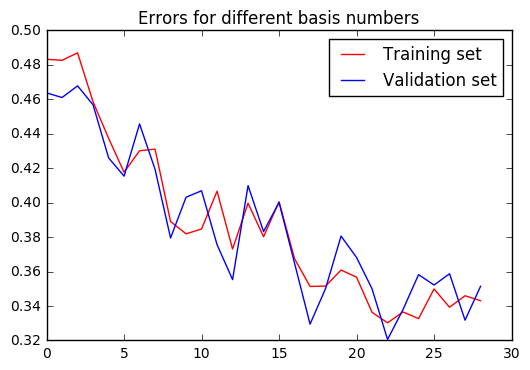

In [6]:
def train_basis_number(xt, yt, xv, yv, maxm, ntimes, basis, means, lamb=0.0):
    trainerrs = []
    validerrs = []
    for m in range(1, maxm):
        ws, trainerr, validerr = train(xt, yt, xv, yv, ntimes, basis, m, means, lamb)
        trainerrs.append(trainerr)
        validerrs.append(validerr)
    return np.array(trainerrs), np.array(validerrs)


plt.title('Errors for different basis numbers')
trainerrs, validerrs = train_basis_number(xt, yt, xv, yv, 30, 3, gauss_basis, means)
train_line, = plt.plot(trainerrs, 'r-', label='Training set')
valid_line, = plt.plot(validerrs, 'b-', label='Validation set')
plt.legend(handles=[train_line, valid_line])
plt.show()

In [ ]:
def train_lambda(xt, yt, xv, yv, num_basis, ntimes, basis, means):
    trainerrs = []
    validerrs = []
    lambs = [l for l in np.linspace(0.0, 1.0, 10)]
    lambs.extend([l for l in np.linspace(1.0, 10.0, 10)])
    for l in lambs:
        ws, trainerr, validerr = train(xt, yt, xv, yv, ntimes, basis, num_basis, means, l)
        trainerrs.append(trainerr)
        validerrs.append(validerr)
    return np.array(lambs), np.array(trainerrs), np.array(validerrs)


plt.title('Errors for different regularization $\lambda$')
lambs, trainerrs, validerrs = train_lambda(xt, yt, xv, yv, 10, 3, gauss_basis, means)
train_line, = plt.plot(lambs, trainerrs, 'r-', label='Training set')
valid_line, = plt.plot(lambs, validerrs, 'b-', label='Validation set')
plt.legend(handles=[train_line, valid_line])
plt.show()